# E-commerce Customer Behavior Analysis Project

## Project Overview
This project analyzes e-commerce customer behavior data to derive actionable insights using machine learning techniques. We combine **clustering** and **classification** approaches to understand customer segments and predict their behaviors.

## Objectives
1. **Customer Segmentation (Using K-means Clustering)**:
   - Group customers based on similar behavioral patterns.
   - Identify distinct customer segments based on:
     - **Purchase behavior**: Total spend, average order value, and category diversity.
     - **Transactional patterns:** Return rate, total items purchased, and average items per order.
     - **Customer attributes:** Age and spend variability.

2. **Predictive Analysis (Using ID3 Decision Tree)**:
   - Predict customer churn probability for each segment.
   - Identify key factors influencing:
     - Customer retention.
     - Purchase behavior.
     - Product returns.

## Expected Outcomes
- Detailed customer segment profiles.
- A churn prediction model with interpretable rules.
- Actionable insights for targeted marketing strategies.
- Identification of customer behavior patterns and risk factors for churn.

In [612]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("Datasets/ecommerce_customer_data.csv")

data.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,31,Female,0


In [613]:
# Check the number of rows and columns

data.shape

(250000, 12)

In [614]:
# Check dataset structure and data types

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202618 non-null  float64
 9   Age                    250000 non-null  int64  
 10  Gender                 250000 non-null  object 
 11  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 22.9+ MB


In [615]:
# Count missing values in each column

data.isna().sum()

Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47382
Age                          0
Gender                       0
Churn                        0
dtype: int64

## Initial Data Exploration

### 1. Dataset Overview
The dataset contains e-commerce customer transactions and behavioral data:
- Total records: 250,000
- Number of features: 12 columns


### 2. Data Structure Analysis (data.info())
#### Column Types:
- **Integer columns (7)**: 
 - Customer ID
 - Product Price
 - Quantity
 - Total Purchase Amount
 - Customer Age
 - Age
 - Churn

- **Float columns (1)**:
 - Returns

- **Object/String columns (5)**:
 - Purchase Date
 - Product Category
 - Payment Method
 - Gender

### 4. Missing Value Analysis
- Only one column contains missing values:
 - 'Returns': 47,382 missing values
- All other columns are complete with no null values

### 5. Data Quality Issues

#### Datatype Issues:
* **Returns Column**:
  * Currently in float format
  * Should be integers (1=returned, 0=no return)
  * Binary classification data

* **Purchase Date Column**:
  * Currently stored as object type
  * Needs conversion to datetime format


* **Product Price and Total Purchase Amount Columns**:
  * Currently stored as integers
  * Must be floats, as they represent price values


#### Data Inconsistencies:
* **Total Purchase Amount Calculation**:
  * Discrepancy between calculated amount (`Price` * `Quantity`) and stored `Total Purchase Amount`
  * Potential data accuracy concern
  * Requires investigation and validation

#### Redundancy Issues:
* Duplicate age information:
  * Both 'Customer Age' and 'Age' columns present
  * Need to verify if values are identical




## Data cleaning

In [616]:
df_clean = data.copy()

# Handle Returns Column - Convert to Integer
print("Before Returns conversion - unique values:", df_clean['Returns'].unique())
df_clean['Returns'] = df_clean['Returns'].fillna(0).astype(int)
print("After Returns conversion - unique values:", df_clean['Returns'].unique())

Before Returns conversion - unique values: [ 1.  0. nan]
After Returns conversion - unique values: [1 0]


In [617]:
# Convert Purchase Date to datetime

df_clean['Purchase Date'] = pd.to_datetime(df_clean['Purchase Date'])
print("\nPurchase Date dtype after conversion:", df_clean['Purchase Date'].dtype)


Purchase Date dtype after conversion: datetime64[ns]


In [618]:
# Calculate expected total purchase amount
df_clean['Product Price'] = df_clean['Product Price'].astype(float)
df_clean['Total Price'] = (df_clean['Product Price'] * df_clean['Quantity']).astype(float)

# Compare calculated total with 'Total Purchase Amount'
discrepancies = df_clean[df_clean['Total Price'] != df_clean['Total Purchase Amount']]

# Investigate discrepancies
print(f"Number of discrepancies: {len(discrepancies)}")
print(discrepancies[['Product Price', 'Quantity', 'Total Purchase Amount', 'Total Price']].head())

Number of discrepancies: 249962
   Product Price  Quantity  Total Purchase Amount  Total Price
0          177.0         1                   2427        177.0
1          174.0         3                   2448        522.0
2          413.0         1                   2345        413.0
3          396.0         3                    937       1188.0
4          259.0         4                   2598       1036.0


In [619]:
# Exclude the 'Total Purchase Amount' column
df_clean = df_clean.drop(columns=['Total Purchase Amount'])

In [620]:
# Check if 'Customer Age' and 'Age' columns are identical
if df_clean['Customer Age'].equals(df_clean['Age']):
    print("'Customer Age' and 'Age' columns are identical. Dropping 'Age' column.")
    df_clean.drop(columns=['Age'], inplace=True)
else:
    print("'Customer Age' and 'Age' columns are not identical.")
    # Investigate differences
    age_differences = df_clean[df_clean['Customer Age'] != df_clean['Age']]
    print(age_differences[['Customer Age', 'Age']].head())

'Customer Age' and 'Age' columns are identical. Dropping 'Age' column.


In [621]:
# Extract Purchase Year and Purchase Month from 'Purchase Date'
df_clean['Purchase Year'] = df_clean['Purchase Date'].dt.year
df_clean['Purchase Month'] = df_clean['Purchase Date'].dt.month

In [622]:
# Re-order columns

cols = ['Customer ID','Gender','Customer Age','Purchase Date','Purchase Year','Purchase Month','Product Category','Product Price','Quantity','Total Price','Payment Method','Returns','Churn']
df_clean = df_clean[cols]

## Data validation

In [623]:
df_clean.head()


,Customer ID,Gender,Customer Age,Purchase Date,Purchase Year,Purchase Month,Product Category,Product Price,Quantity,Total Price,Payment Method,Returns,Churn
0,44605,Female,31,2023-05-03 21:30:02,2023,5,Home,177.0,1,177.0,PayPal,1,0
1,44605,Female,31,2021-05-16 13:57:44,2021,5,Electronics,174.0,3,522.0,PayPal,1,0
2,44605,Female,31,2020-07-13 06:16:57,2020,7,Books,413.0,1,413.0,Credit Card,1,0
3,44605,Female,31,2023-01-17 13:14:36,2023,1,Electronics,396.0,3,1188.0,Cash,0,0
4,44605,Female,31,2021-05-01 11:29:27,2021,5,Books,259.0,4,1036.0,PayPal,1,0


In [624]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Customer ID       250000 non-null  int64         
 1   Gender            250000 non-null  object        
 2   Customer Age      250000 non-null  int64         
 3   Purchase Date     250000 non-null  datetime64[ns]
 4   Purchase Year     250000 non-null  int32         
 5   Purchase Month    250000 non-null  int32         
 6   Product Category  250000 non-null  object        
 7   Product Price     250000 non-null  float64       
 8   Quantity          250000 non-null  int64         
 9   Total Price       250000 non-null  float64       
 10  Payment Method    250000 non-null  object        
 11  Returns           250000 non-null  int64         
 12  Churn             250000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(2), int64(5), objec

In [625]:
df_clean.isna().sum()

Customer ID         0
Gender              0
Customer Age        0
Purchase Date       0
Purchase Year       0
Purchase Month      0
Product Category    0
Product Price       0
Quantity            0
Total Price         0
Payment Method      0
Returns             0
Churn               0
dtype: int64

In [626]:
df_clean.describe()

,Customer ID,Customer Age,Purchase Date,Purchase Year,Purchase Month,Product Price,Quantity,Total Price,Returns,Churn
count,250000.000000,250000.000000,250000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.00000
mean,25017.632092,43.798276,2021-11-06 19:26:22.286192384,2021.377136,6.190376,254.742724,3.004936,765.954660,0.405904,0.20052
min,1.000000,18.000000,2020-01-01 00:07:26,2020.000000,1.000000,10.000000,1.000000,10.000000,0.000000,0.00000
25%,12590.000000,30.000000,2020-12-03 08:10:12,2020.000000,3.000000,132.000000,2.000000,288.000000,0.000000,0.00000
50%,25011.000000,44.000000,2021-11-06 07:39:08.500000,2021.000000,6.000000,255.000000,3.000000,604.000000,0.000000,0.00000
75%,37441.250000,57.000000,2022-10-11 01:21:56.249999872,2022.000000,9.000000,377.000000,4.000000,1135.000000,1.000000,0.00000
max,50000.000000,70.000000,2023-09-13 18:42:49,2023.000000,12.000000,500.000000,5.000000,2500.000000,1.000000,1.00000
std,14412.515718,15.364915,NaN,1.074712,3.353238,141.738104,1.414737,593.494204,0.491067,0.40039


## Exploratory Data Analysis (EDA)

### 1. Monthly Purchase Trends

**Insight:** Identify seasonal trends

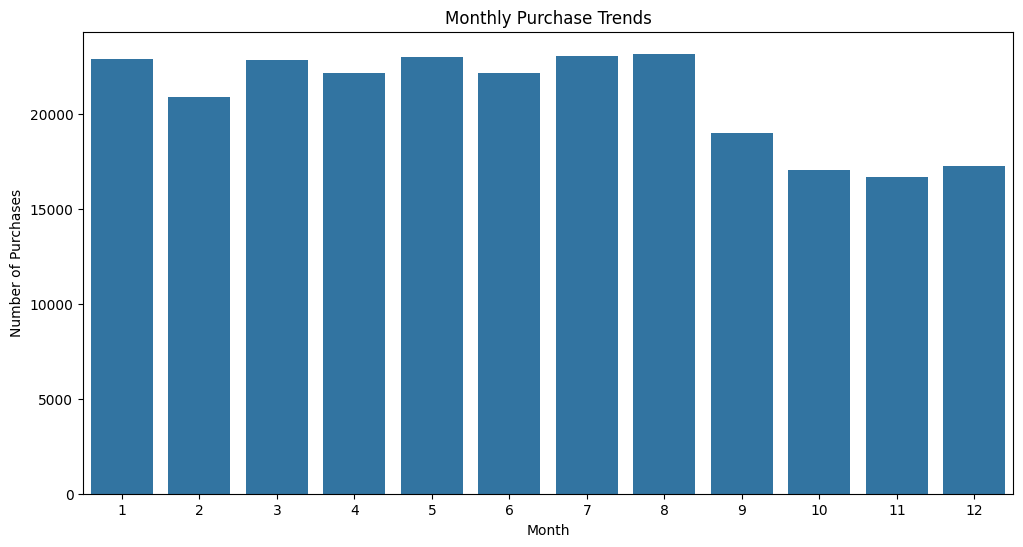

In [627]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Purchase Month', data=df_clean)
plt.title('Monthly Purchase Trends')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.show()

### 2. Yearly Purchase Trends

**Insight:** Check if purchases are increasing or decreasing over the years.

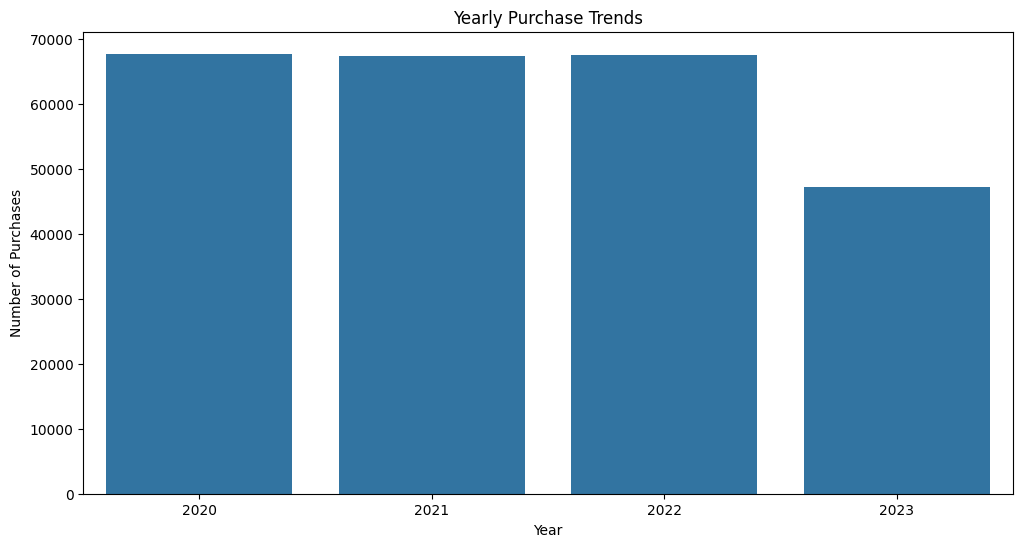

In [628]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Purchase Year', data=df_clean)  
plt.title('Yearly Purchase Trends')
plt.xlabel('Year')
plt.ylabel('Number of Purchases')
plt.show()

### 3. Most Popular Product Categories

**Insight:** Identify best-selling product categories.

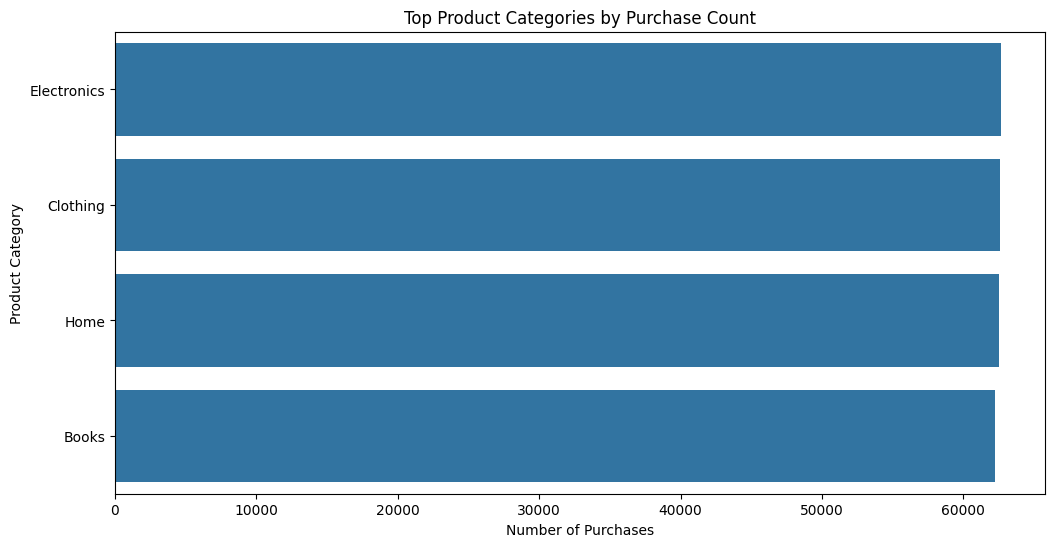

In [629]:
plt.figure(figsize=(12, 6))
sns.countplot(
    y='Product Category',
    data=df_clean,
    order=df_clean['Product Category'].value_counts().index
)
plt.title('Top Product Categories by Purchase Count')
plt.xlabel('Number of Purchases')
plt.ylabel('Product Category')
plt.show()

### 4. Analyze distributions of numerical features

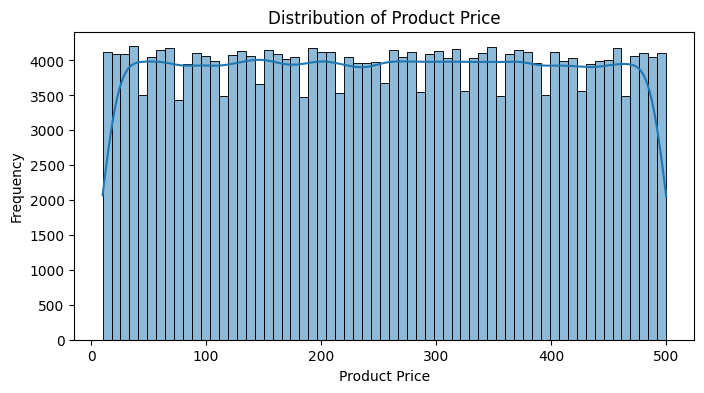

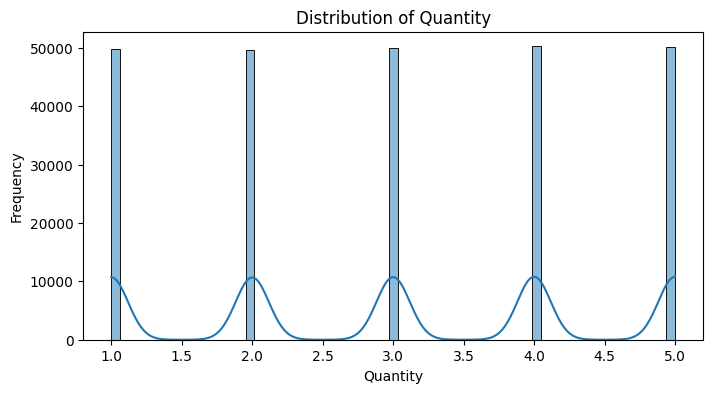

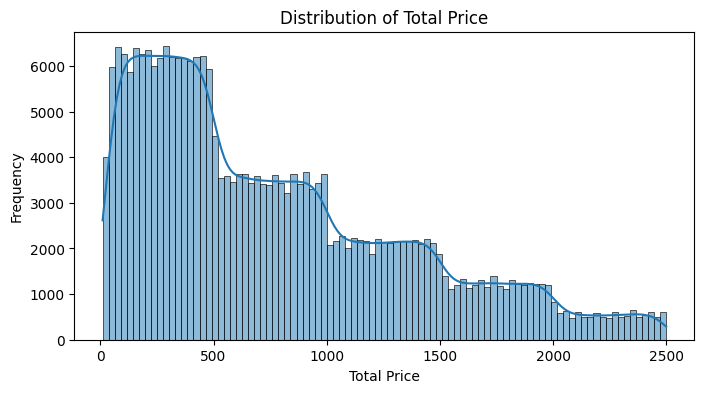

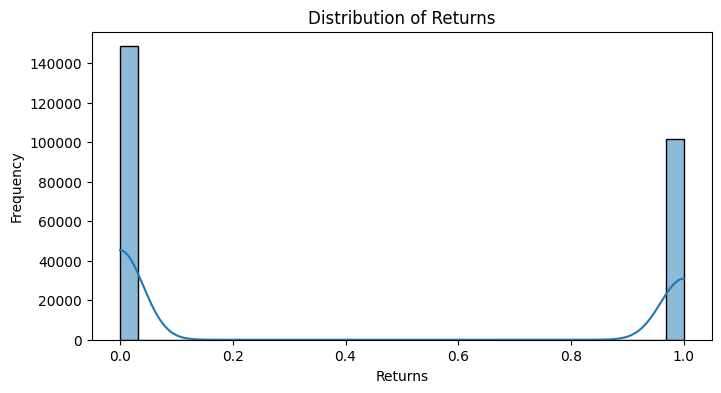

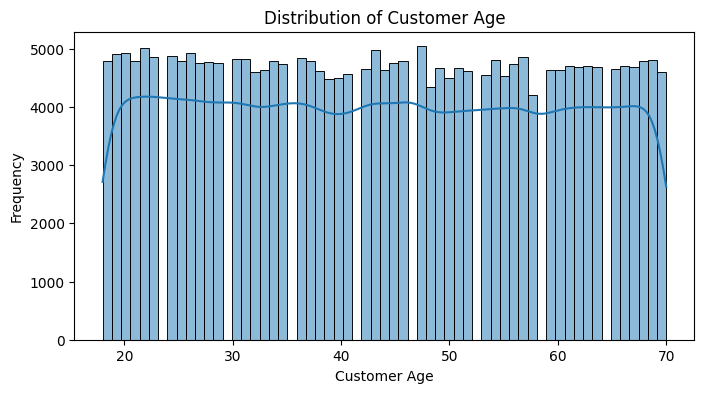

In [630]:
numerical_cols = ['Product Price', 'Quantity', 'Total Price', 'Returns', 'Customer Age']

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_clean[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

### 5. Average Spending by Payment Method and Gender

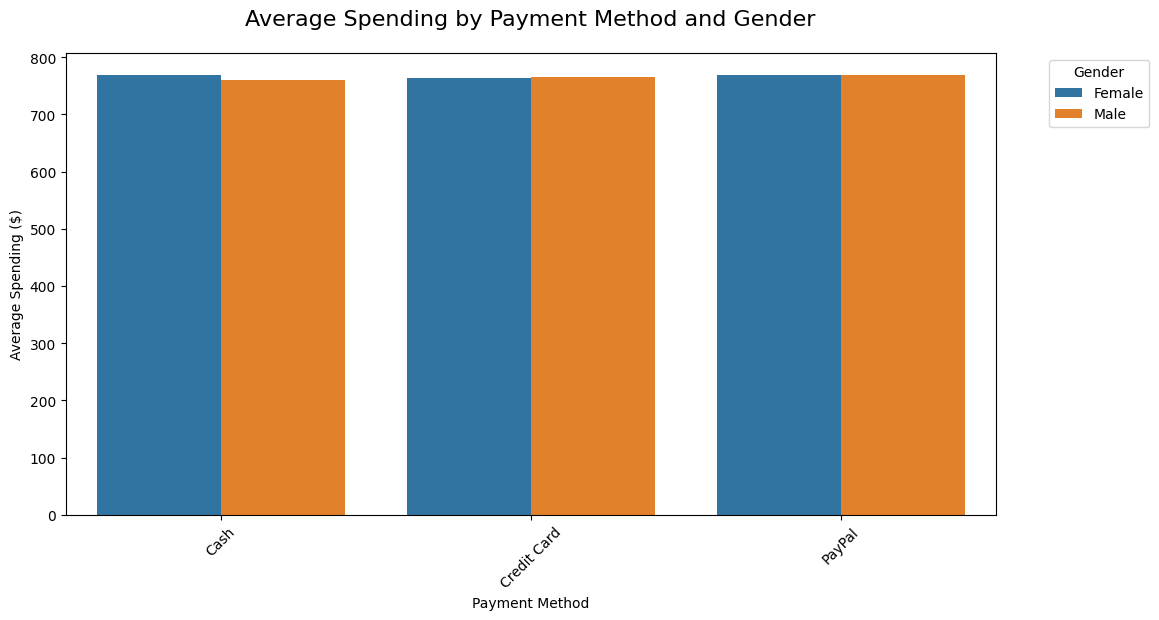

In [631]:
avg_spending_payment = df_clean.groupby(['Gender', 'Payment Method'])['Total Price'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(
    x='Payment Method',
    y='Total Price',
    hue='Gender',
    data=avg_spending_payment,
)
plt.title('Average Spending by Payment Method and Gender', fontsize=16, pad=20)
plt.xlabel('Payment Method')
plt.ylabel('Average Spending ($)')
plt.xticks(rotation=45)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 6. Churn Rate by Product Category and Gender

**Insight:** Analyze how churn rates vary across product categories and genders.

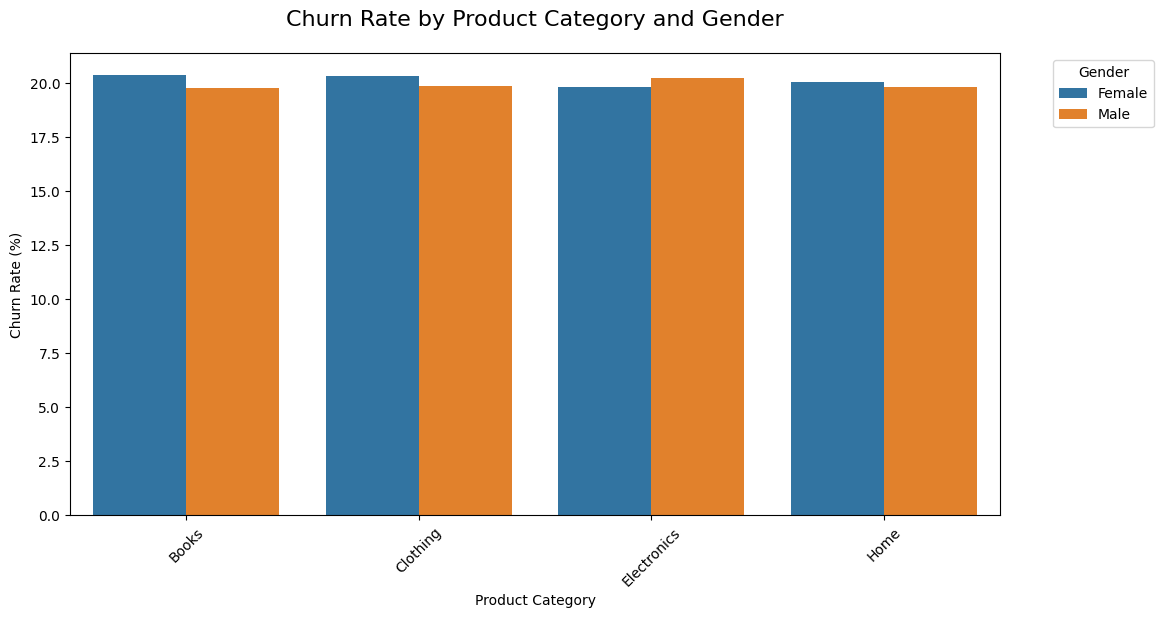

In [632]:
churn_rate_category = df_clean.groupby(['Gender', 'Product Category'])['Churn'].mean().reset_index()
churn_rate_category['Churn Rate (%)'] = churn_rate_category['Churn'] * 100

plt.figure(figsize=(12, 6))
sns.barplot(
    x='Product Category',
    y='Churn Rate (%)',
    hue='Gender',
    data=churn_rate_category
)
plt.title('Churn Rate by Product Category and Gender', fontsize=16, pad=20)
plt.xlabel('Product Category')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 7. Returns by Purchase Year and Gender

**Insight:** Compare return rates over time for each gender.

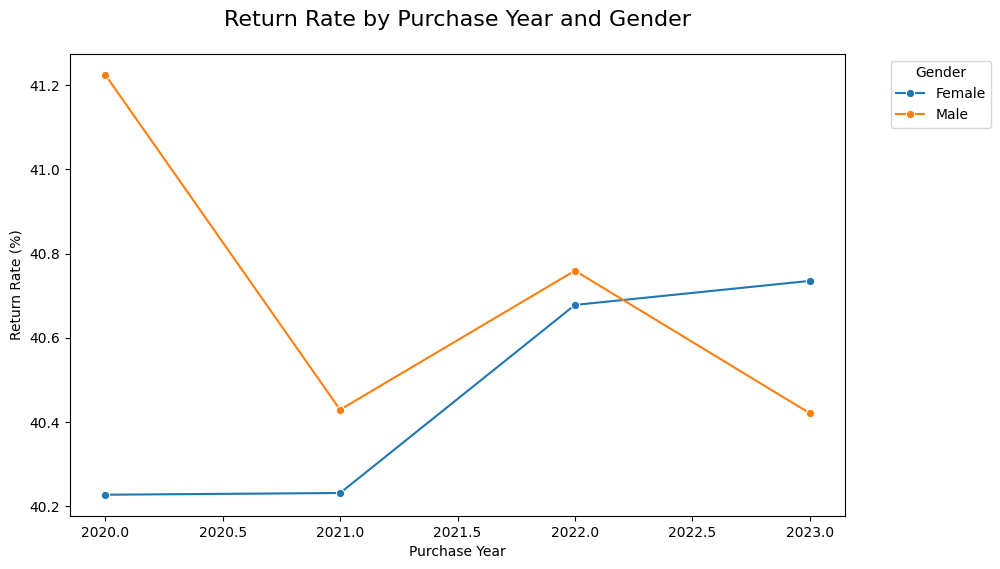

In [633]:
return_rate_year = df_clean.groupby(['Gender', 'Purchase Year'])['Returns'].mean().reset_index()
return_rate_year['Return Rate (%)'] = return_rate_year['Returns'] * 100

plt.figure(figsize=(10, 6))
sns.lineplot(
    x='Purchase Year',
    y='Return Rate (%)',
    hue='Gender',
    data=return_rate_year,
    marker='o'
)
plt.title('Return Rate by Purchase Year and Gender', fontsize=16, pad=20)
plt.xlabel('Purchase Year')
plt.ylabel('Return Rate (%)')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 8. Customer Age vs. Total Spending

explore the relationship between **customer age**, **total spending**, and **churn behavior**. By visualizing how spending patterns vary across different age groups and how they correlate with churn.

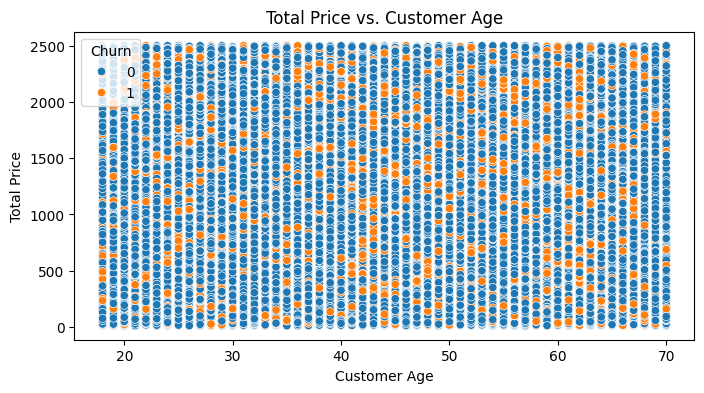

In [634]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df_clean, x='Customer Age', y='Total Price', hue='Churn')
plt.title('Total Price vs. Customer Age')
plt.xlabel('Customer Age')
plt.ylabel('Total Price')
plt.show()

### 9. Number of Customers with Churn and Returns by Age Group

**Insight:** identify which age groups exhibit the highest number of churn and return cases.

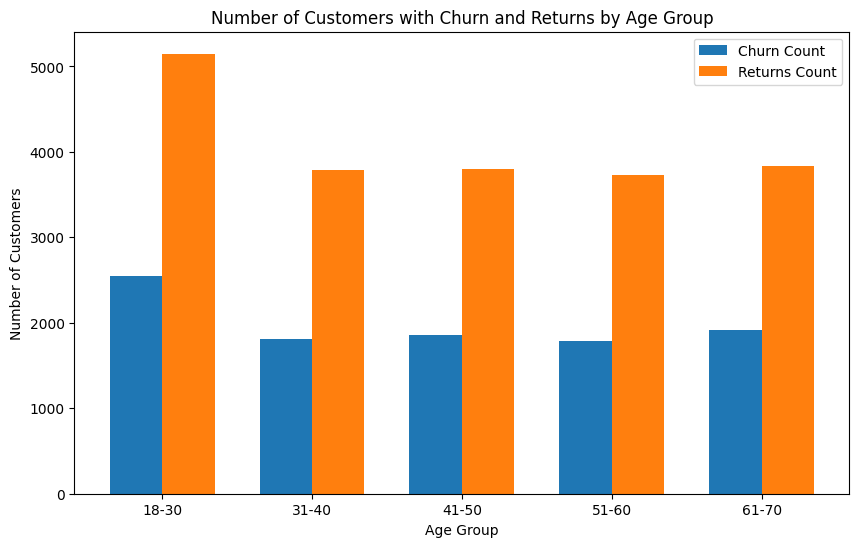

In [635]:
# Define age bins and labels
bins = [18, 30, 40, 50, 60, 70]
labels = ['18-30', '31-40', '41-50', '51-60', '61-70']

# Create a new column for age groups
df_clean['Age Group'] = pd.cut(df_clean['Customer Age'], bins=bins, labels=labels, include_lowest=True)
df_customers = df_clean.drop_duplicates(subset='Customer ID')

agg_counts = df_customers.groupby('Age Group', observed=True).agg(
    Churn_Count=('Churn', 'sum'),
    Returns_Count=('Returns', 'sum'),
    Total_Customers=('Customer ID', 'count')
).reset_index()

positions = np.arange(len(agg_counts))
width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(positions - width/2, agg_counts['Churn_Count'], width, label='Churn Count')
ax.bar(positions + width/2, agg_counts['Returns_Count'], width, label='Returns Count')

ax.set_xlabel('Age Group')
ax.set_ylabel('Number of Customers')
ax.set_title('Number of Customers with Churn and Returns by Age Group')
ax.set_xticks(positions)
ax.set_xticklabels(agg_counts['Age Group'])
ax.legend()

plt.show()


# Observations

## Customer Demographics
1. **Age Distribution**
   - Customer ages range from 20 to 70 years
   - Relatively even distribution across age groups
   - Slight peak in the 45-55 age range
   - Consistent customer base across different generations

## Spending Patterns
1. **Payment Methods**
   - Average spending is consistent (~$750) across all payment methods (Cash, Credit Card, PayPal)
   - Minimal gender-based differences in spending across payment types
   - Credit card usage shows slightly higher average spending

2. **Purchase Trends**
   - Monthly trends show:
     - Higher purchase volumes in early months (January-August)
     - Significant decline in purchases during Q4 (September-December)
   - Yearly trends indicate:
     - Stable purchase volumes from 2020-2022 (~67,000 purchases/year)
     - Notable decline in 2023 (dropped to ~47,000 purchases)

3. **Price Distribution**
   - Product prices mostly range from 0-500
   - Total purchase amounts show a right-skewed distribution
     - Majority of transactions under 1,000
     - Long tail extending to 2,500

## Customer Retention and Returns
1. **Churn Rate Analysis**
   - Consistent churn rates (~20%) across all product categories
   - Minor gender differences in churn behavior:
     - Slightly higher female churn in Books and Clothing
     - Slightly higher male churn in Electronics
     - Similar churn rates in Home category

2. **Return Rate Trends**
   - Return rates fluctuated between 40-41.5% over 2020-2023
   - Gender-specific patterns:
     - Male customers showed higher initial return rates in 2020 (41.2%)
     - Female customers showed more stable return rates
     - Convergence of return rates between genders by 2023

3. **Age Group Analysis of Churn and Returns**
   - Younger customers (18-30) show significantly higher churn and return rates
     - Highest number of both churned customers (approximately 2,500) and returns (approximately 5,000)
   - Middle-aged and older segments (31-70) display more stable behavior
     - Consistent churn levels around 1,800-2,000 customers across these groups
     - Returns maintain steady rate of ~3,800 customers per age group

## Product Analysis
1. **Category Performance**
   - Four main product categories: Books, Clothing, Electronics, and Home
   - Even distribution of sales across categories
   - Quantity distribution shows distinct purchasing patterns:
     - Most customers buy in specific quantity increments
     - Clear peaks at 1, 2, 3, 4, and 5 units


# Customer Segmentation (Using K-means Clustering)

## 1. Data Preprocessing

In [636]:
from sklearn.preprocessing import StandardScaler
from custom_kmeans import CustomKMeans 

customer_data = df_clean.groupby('Customer ID').agg({
    'Total Price': ['sum', 'mean', 'std'],          
    'Customer Age': 'mean',                         
    'Returns': 'sum',                                
    'Churn': 'max',                                 
    'Product Category': 'nunique',                   
    'Quantity': ['sum', 'mean']                      
}).reset_index()


customer_data.columns = [
    'Customer ID', 
    'Total_Spend',             
    'Average_Order_Value',     
    'Spend_Variability',       
    'Age',                     
    'Total_Returns',           
    'Churn',                   
    'Category_Diversity',      
    'Total_Items',             
    'Average_Items_Per_Order'  
]

customer_data['Return_Rate'] = customer_data['Total_Returns'] / customer_data['Total_Items']
customer_data['Average_Spend_Per_Item'] = customer_data['Total_Spend'] / customer_data['Total_Items']

features_for_clustering = [
    'Total_Spend',
    'Average_Order_Value',
    'Spend_Variability',
    'Age',
    'Return_Rate',
    'Category_Diversity',
    'Average_Items_Per_Order',
    'Average_Spend_Per_Item',
    'Churn'
]


customer_data = customer_data.fillna({
    'Spend_Variability': 0,
    'Return_Rate': 0,
    'Average_Spend_Per_Item': customer_data['Average_Spend_Per_Item'].mean()
})


scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_data[features_for_clustering])


## 2. Find optimal k

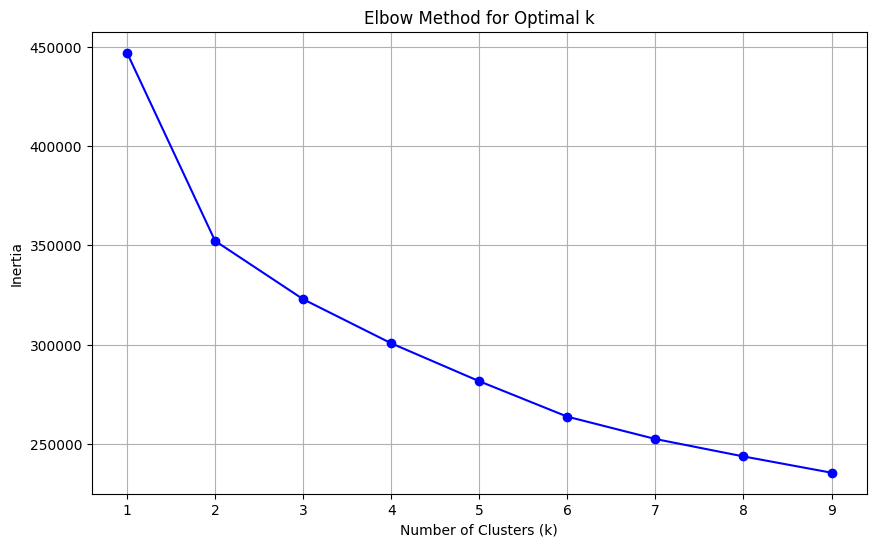

In [637]:

from custom_kmeans import CustomKMeans

inertias = []
k_range = range(1, 10)

for k in k_range:
    kmeans = CustomKMeans(n_clusters=k, max_iter=100)
    labels, centroids = kmeans.fit(X_scaled)
    distances = np.sqrt(((X_scaled[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    min_distances = np.min(distances, axis=1)
    inertia = np.sum(min_distances ** 2)
    
    inertias.append(inertia)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


## Choosing the Optimal Number of Clusters (k)  

The **Elbow Method** is used to determine the optimal number of clusters for K-Means. In the graph above.  

We chose **k = 4** because:  
- The inertia decreases rapidly up to **k = 4**, forming an "elbow" shape.  
- Beyond **k = 4**, the rate of decrease slows down, indicating diminishing returns.  
- This suggests that **4 clusters** provide a good balance between model complexity and variance reduction.  

k = 4 is an optimal choice for segmenting customers effectively.  


## 3. Apply K-means with optimal k

In [638]:

optimal_k = 4 
kmeans = CustomKMeans(n_clusters=optimal_k)
labels, centroids = kmeans.fit(X_scaled)

customer_data['Cluster'] = labels

cluster_summary = customer_data.groupby('Cluster').agg({
    'Total_Spend': 'mean',
    'Average_Order_Value': 'mean',
    'Spend_Variability': 'mean',
    'Age': 'mean',
    'Return_Rate': 'mean',
    'Category_Diversity': 'mean',
    'Total_Items': 'mean',
    'Average_Items_Per_Order': 'mean',
    'Average_Spend_Per_Item': 'mean',
    'Churn': 'mean'
}).round(2)

print("Cluster Summary:")
print(cluster_summary)


Cluster Summary:
         Total_Spend  Average_Order_Value  Spend_Variability    Age  \
Cluster                                                               
0            6575.48               957.82             674.84  43.84   
1            3475.83               640.78             496.86  43.71   
2            1401.57               425.14             241.45  43.99   
3            3530.94              1093.13             676.80  43.89   

         Return_Rate  Category_Diversity  Total_Items  \
Cluster                                                 
0               0.13                3.53        22.69   
1               0.14                3.21        15.86   
2               0.21                2.15         7.82   
3               0.12                2.12        11.34   

         Average_Items_Per_Order  Average_Spend_Per_Item  Churn  
Cluster                                                          
0                           3.27                  295.63   0.20  
1              

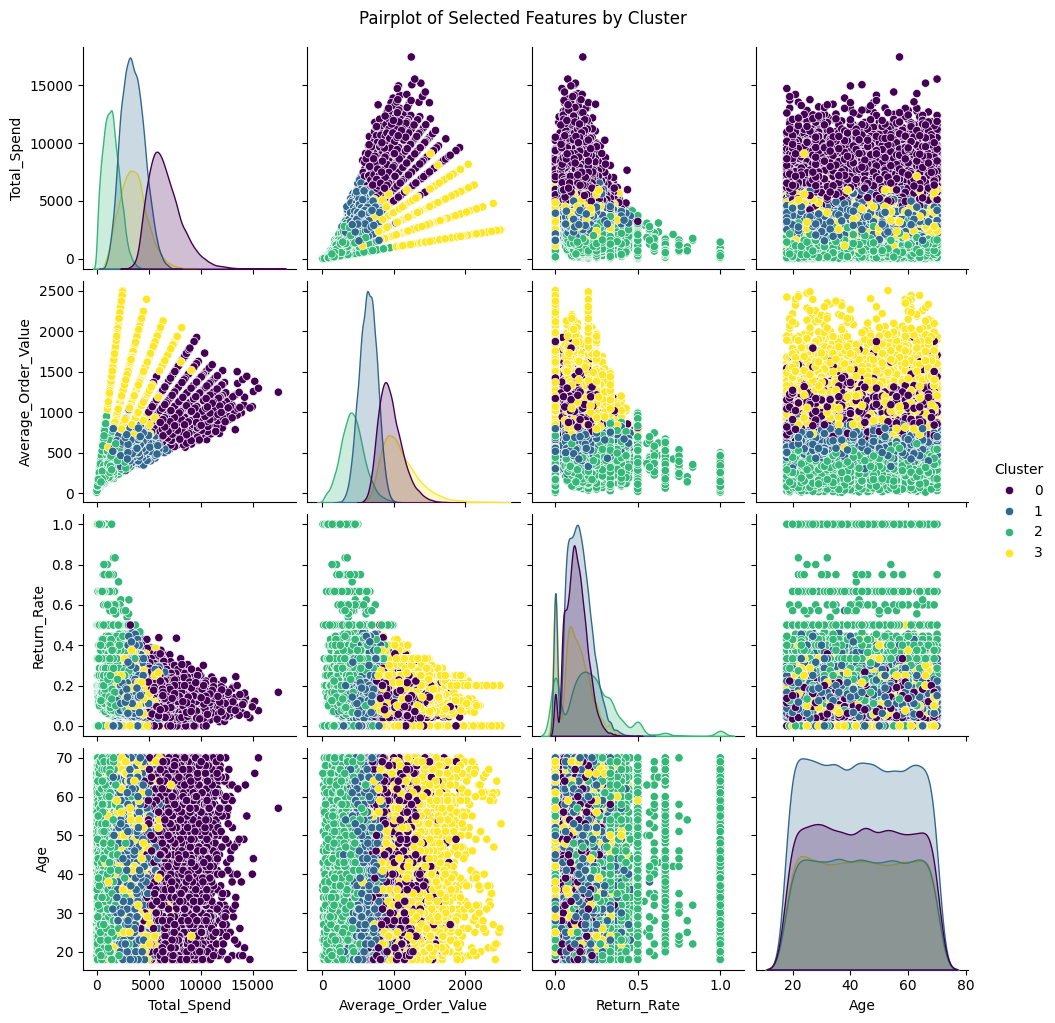

In [639]:
selected_features = ['Total_Spend', 'Average_Order_Value', 'Return_Rate', 'Age']
sns.pairplot(customer_data[selected_features + ['Cluster']], hue='Cluster', palette='viridis')
plt.suptitle("Pairplot of Selected Features by Cluster", y=1.02)
plt.show()

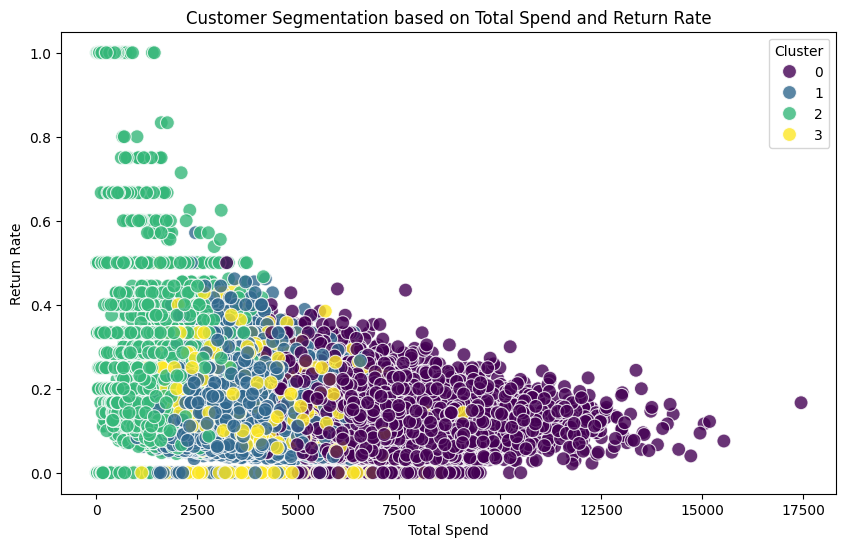

In [640]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customer_data, 
    x='Total_Spend', 
    y='Return_Rate',
    hue='Cluster',
    palette='viridis',
    s=100,
    alpha=0.8
)
plt.title('Customer Segmentation based on Total Spend and Return Rate')
plt.xlabel('Total Spend')
plt.ylabel('Return Rate')
plt.legend(title='Cluster')
plt.show()

## Customer Segmentation Analysis

### Cluster 0 (Purple): High-Spending, Low-Return Customers (Loyal High-Value Shoppers)
- **Description:** These customers have high total spend but low return rates.
- **Key Points:**
  - Represent the most valuable customers who make frequent purchases and rarely return items.
  - Ideal for loyalty programs and personalized offers to increase retention and lifetime value.

### Cluster 1 (Blue): Mid-Spenders with Moderate Return Rates
- **Description:** Customers in this segment have moderate total spend and moderate return rates.
- **Key Points:**
  - Stable contributors to revenue.
  - Some customers might be prone to returns.
- **Strategies:** Targeted recommendations and discounts to maximize their spending.

### Cluster 2 (Green): Low-Spending, High-Return Customers (At-Risk Shoppers)
- **Description:** This group has the lowest total spend and high return rates.
- **Key Points:**
  - May be price-sensitive or dissatisfied with products.
- **Strategies:** Enhance customer support, improve product descriptions, and adjust return policies to reduce churn.

### Cluster 3 (Yellow): Mid-Spenders with Stable Return Rates
- **Description:** Customers in this segment have **moderate total spend** and **stable return rates**.
- **Key Points:**
  - They are **occasional or seasonal shoppers** who purchase reliably but not frequently.
  - Their spending behavior is similar to **Cluster 1 (Blue)** but may have different purchase patterns.
- **Strategies:** 
  - Encourage **repeat purchases** through loyalty programs or personalized promotions.


# Predictive Analysis (Using ID3 Decision Tree)

## Feature Importance Using Decision Tree

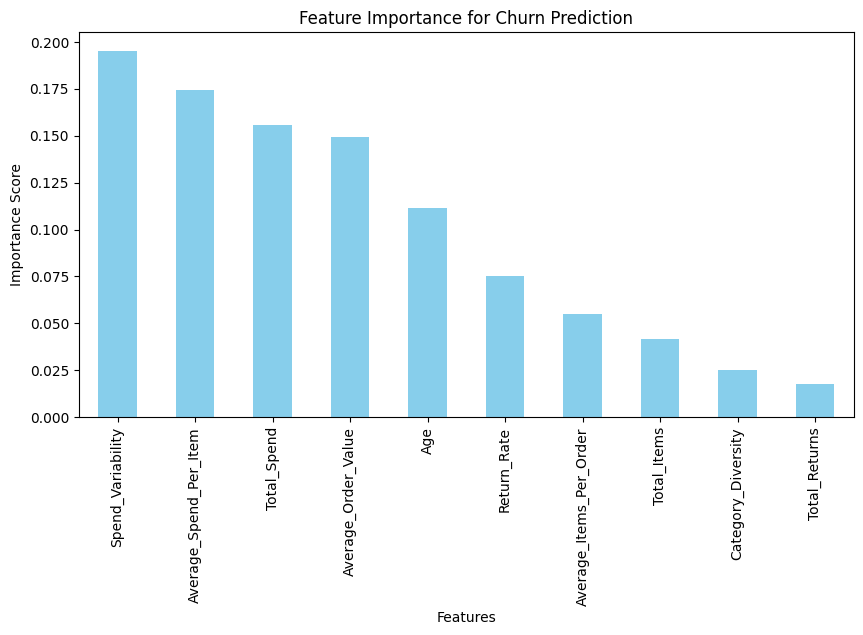

Top Features:
 Spend_Variability          0.195409
Average_Spend_Per_Item     0.174398
Total_Spend                0.155664
Average_Order_Value        0.149093
Age                        0.111326
Return_Rate                0.075090
Average_Items_Per_Order    0.054909
Total_Items                0.041489
Category_Diversity         0.024951
Total_Returns              0.017671
dtype: float64


In [641]:
from sklearn.tree import DecisionTreeClassifier

X = customer_data.drop(columns=["Customer ID", "Churn", "Cluster"])  
y = customer_data["Churn"]

X_encoded = X.apply(lambda x: x.astype("category").cat.codes if x.dtype == "object" else x)

# Train a decision tree
tree = DecisionTreeClassifier(criterion="entropy", random_state=42)
tree.fit(X_encoded, y)

# Get feature importance
feature_importance = pd.Series(tree.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(10, 5))
feature_importance.plot(kind="bar", color="skyblue")
plt.title("Feature Importance for Churn Prediction")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

print("Top Features:\n", feature_importance.head(10))

## Correlation Analysis

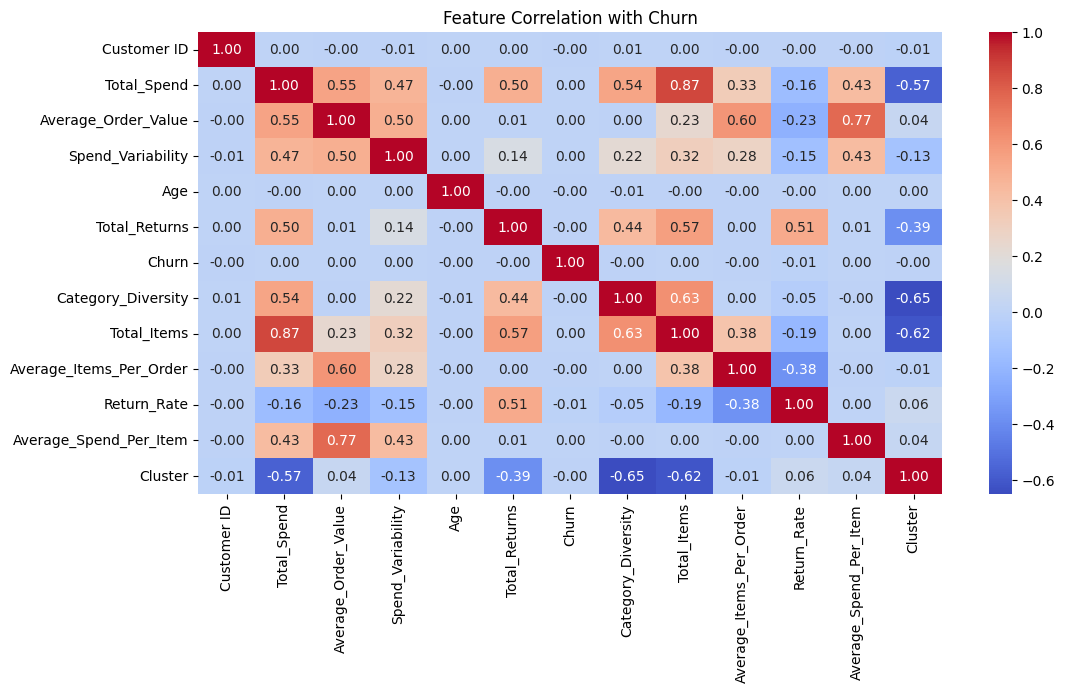

Churn                      1.000000
Total_Spend                0.004138
Spend_Variability          0.003553
Average_Spend_Per_Item     0.003039
Average_Order_Value        0.002046
Total_Items                0.001700
Category_Diversity        -0.000889
Average_Items_Per_Order   -0.000910
Age                       -0.001094
Total_Returns             -0.001734
Customer ID               -0.002448
Cluster                   -0.004487
Return_Rate               -0.005648
Name: Churn, dtype: float64


In [642]:
correlation_matrix = customer_data.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation with Churn")
plt.show()

print(correlation_matrix["Churn"].sort_values(ascending=False))

## Select features for Decision Tree

In [643]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Train a model to find top features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=5)  
rfe.fit(X_encoded, y)

# Print the selected features
selected_features = X_encoded.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Total_Spend', 'Average_Order_Value', 'Spend_Variability', 'Age',
       'Average_Spend_Per_Item'],
      dtype='object')


## Data binning

In [644]:

import pandas as pd
import numpy as np


total_spend_bins = [0, 1000, 3000, 6000, np.inf]
avg_order_value_bins = [0, 500, 1000, 2000, np.inf]
spend_variability_bins = [0, 500, 1500, 3000, np.inf]
age_bins = [18, 30, 50, 70, np.inf]  
avg_spend_per_item_bins = [0, 100, 300, 600, np.inf]

customer_data["Total_Spend_Bin"] = pd.cut(customer_data["Total_Spend"], bins=total_spend_bins, labels=["Low", "Medium", "High", "Very High"])
customer_data["Average_Order_Value_Bin"] = pd.cut(customer_data["Average_Order_Value"], bins=avg_order_value_bins, labels=["Low", "Medium", "High", "Very High"])
customer_data["Spend_Variability_Bin"] = pd.cut(customer_data["Spend_Variability"], bins=spend_variability_bins, labels=["Stable", "Moderate", "High", "Very High"])
customer_data["Age_Bin"] = pd.cut(customer_data["Age"], bins=age_bins, labels=["Young", "Middle", "Senior", "Elder"])
customer_data["Average_Spend_Per_Item_Bin"] = pd.cut(customer_data["Average_Spend_Per_Item"], bins=avg_spend_per_item_bins, labels=["Low", "Medium", "High", "Very High"])

binned_features = ["Total_Spend_Bin", "Average_Order_Value_Bin", "Spend_Variability_Bin", "Age_Bin", "Average_Spend_Per_Item_Bin"]
customer_data[binned_features] = customer_data[binned_features].apply(lambda x: x.astype("category").cat.codes)

print(customer_data.head())


   Customer ID  Total_Spend  Average_Order_Value  Spend_Variability   Age  \
0            1       5600.0          1866.666667         728.943299  67.0   
1            2       6459.0          1076.500000         733.490763  42.0   
2            3       3613.0           903.250000         930.772931  31.0   
3            4       4339.0           867.800000         673.754184  37.0   
4            5       2263.0           452.600000         314.805178  24.0   

   Total_Returns  Churn  Category_Diversity  Total_Items  \
0              0      0                   3           15   
1              4      0                   4           18   
2              0      0                   3           15   
3              3      0                   4           19   
4              3      0                   2           13   

   Average_Items_Per_Order  Return_Rate  Average_Spend_Per_Item  Cluster  \
0                     5.00     0.000000              373.333333        3   
1                     3.


### ID3 Decision Tree WITHOUT SMOTE ###
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      7947
           1       0.00      0.00      0.00      1986

    accuracy                           0.80      9933
   macro avg       0.40      0.50      0.44      9933
weighted avg       0.64      0.80      0.71      9933

Confusion Matrix:
 [[7947    0]
 [1986    0]]


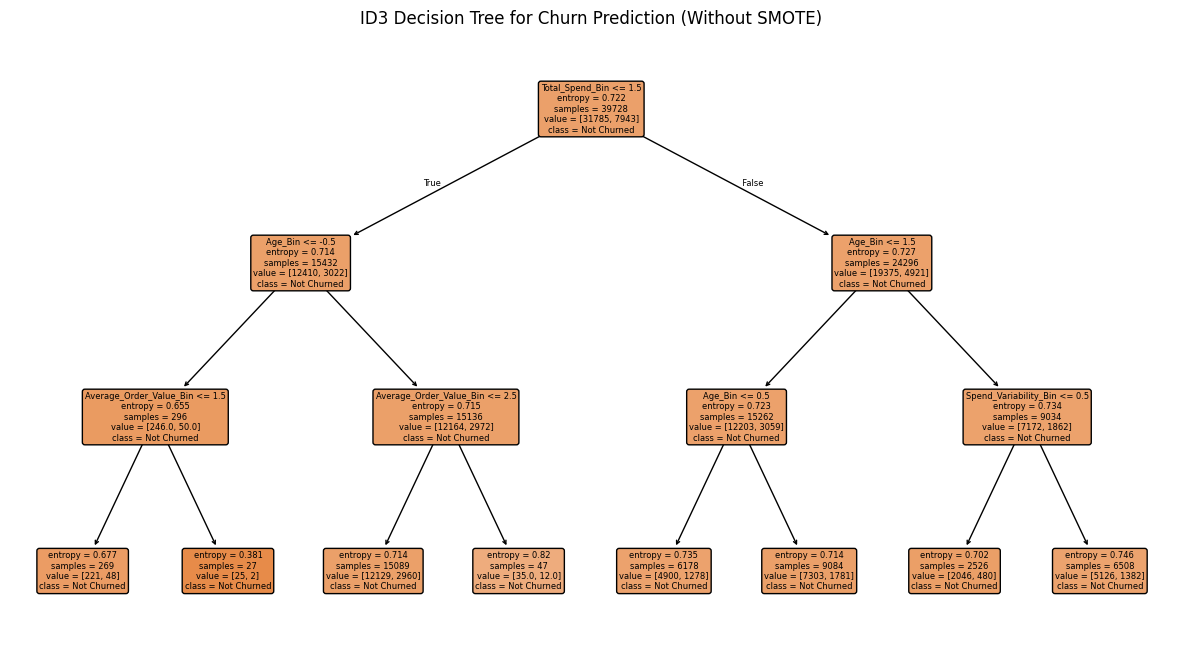

In [645]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


X = customer_data[binned_features]  
y = customer_data["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

decision_tree_no_smote = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
decision_tree_no_smote.fit(X_train, y_train)

y_pred_no_smote = decision_tree_no_smote.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_no_smote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_no_smote))

plt.figure(figsize=(15, 8))
plot_tree(decision_tree_no_smote, feature_names=X.columns, class_names=["Not Churned", "Churned"], filled=True, rounded=True)
plt.title("ID3 Decision Tree for Churn Prediction)")
plt.show()


After running the **ID3 Decision Tree**, we observe:

- **The model predicts "Not Churned" (0) for all customers.**
- **Churned customers (1) are ignored**, leading to **0 recall for Churned class**.
- This happens due to **severe class imbalance** (too many "Not Churned" customers).

To fix this, we use **SMOTE (Synthetic Minority Over-sampling Technique)**, which:
1. **Generates synthetic churned customers**, balancing the dataset.
2. **Prevents the tree from overfitting to "Not Churned".**
3. **Increases recall for "Churned" customers.**


### ID3 Decision Tree WITH SMOTE ###
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.40      0.45      7947
           1       0.50      0.61      0.55      7946

    accuracy                           0.50     15893
   macro avg       0.50      0.50      0.50     15893
weighted avg       0.50      0.50      0.50     15893

Confusion Matrix:
 [[3180 4767]
 [3135 4811]]


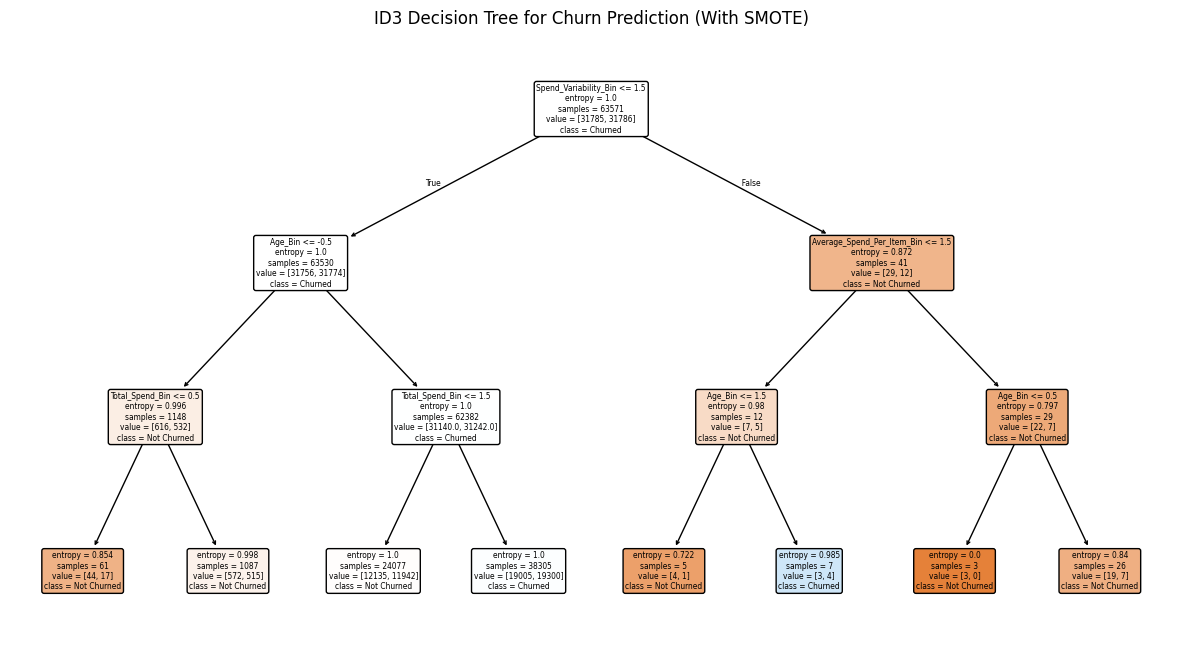

In [646]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

decision_tree_smote = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
decision_tree_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = decision_tree_smote.predict(X_test_smote)
print("Classification Report:\n", classification_report(y_test_smote, y_pred_smote))
print("Confusion Matrix:\n", confusion_matrix(y_test_smote, y_pred_smote))

plt.figure(figsize=(15, 8))
plot_tree(decision_tree_smote, feature_names=X.columns, class_names=["Not Churned", "Churned"], filled=True, rounded=True)
plt.title("ID3 Decision Tree for Churn Prediction")
plt.show()

### **Model Performance Analysis**
After applying **SMOTE** and training the **ID3 Decision Tree**, we achieved an **accuracy of 50%**. The model shows balanced precision but struggles to make strong distinctions between churned and non-churned customers.  

This result suggests that while the decision tree can identify some churn patterns, it may not be the best model for this case.

---

I chose the ID3 Decision Tree because I studied it in my courses and wanted to apply my knowledge in a real-world scenario. While more advanced models might perform better, this was an opportunity to reinforce my understanding of decision trees and entropy-based classification.  

Other models could provide better results.  
